In [ ]:
from scipy.fftpack import fft, ifft
import numpy as np
import convolution_utils

moments = convolution_utils.Distribution.moments_from_cumulants(calc_light_cumulants)

def temp_f(w, moments):
    return sum([(-1)**k/math.factorial(k)*w**(2*k)*moments[k] for k in range(len(moments))])

x1 = [temp_f(w, moments) for w in range(-200, 200, 10)]
x2 = [w*temp_f(w, moments) for w in range(-200, 200, 10)]

y = fft(x1).real + fft(x2).imag
plt.plot(y)

In [ ]:
def moment_generating_function(w, moments):
    return sum([
        (1j*w)**k/math.factorial(k)*moments[k]
        for k in range(len(moments))
    ])

In [ ]:
from scipy.fftpack import fft, ifft

x = list()
y = list()
for k in range(1, 2):
    x.append([moment_generating_function(w, moments) for w in range(-2000, 2000, 10)])
    y.append(ifft(x[k-1]))
    plt.plot(y[k-1][:20].real)
    plt.show()
light_dist.plot(show=True)

In [ ]:
import time
N = 200
x = [moment_generating_function(w, moments) for w in range(N)]
y = ifft(x).real[:20].tolist()
zombie = Distribution(y, [t for t in range(0,20)])
zombie.normalize()
plt.plot(zombie.x, zombie.dist_array)

In [ ]:
import cmath

def ift(x, f):
    N = len(x)
    return [sum([x[k]*cmath.exp(2*cmath.pi*1j*n*k/(N*f))/N/f for k in range(N)]) for n in range(N*f)]

N = 200
x = [moment_generating_function(w, moments) for w in range(-N, N)]
y = np.array(ift(x, 1)[:20]).real.tolist()
zombie = Distribution(y, [t for t in range(20)])
zombie.normalize()
plt.plot(zombie.x, zombie.dist_array)

In [ ]:
print(zombie.moment(0))
zombie2.normalize()
light_dist.normalize()
print(zombie2.moment(0))
print(light_dist.moment(0))
print(zombie.moment(0))
Plot.plot([light_dist, zombie, zombie2], 'Light distributions', 'Time (ns)',
          'Normalized number of photons', ['greisen', 'reconstruct', 'interpolate'], plot_path+'light_comparison.png')

In [ ]:
from scipy.interpolate import interp1d

zombie.plot(show=True)
d = interp1d(zombie.x, zombie.dist_array, kind='cubic')
dist = Distribution(d(times).tolist(), times)
dist.discretize()
Plot.plot([light_dist, dist], 'Light distributions', 'Time (ns)',
          'Normalized number of photons', ['greisen', 'parametrization'], plot_path+'light_comparison.png')

In [ ]:
%run setup.py build_ext --inplace

In [ ]:
%run pmt_signal.py 10000000 plot

In [ ]:
moments = Distribution.moments_from_cumulants(calc_light_cumulants)
moments = light_dist.moments(6)

In [ ]:
from scipy import special, integrate
import numpy as np

def jacobi_recreate(t, moments):
    t = np.array(t)
    l = len(moments)
    jacobi = [ special.jacobi(i,0,0) for i in range(l) ] # define jacobi polys in range [-1,1]
    x = lambda s: -1+2*(s-t[0])/(t[-1]-t[0]) # for variable change from [-1,1] to [x0,x1]
    orthopol = list()
    
    for j in range(l):
        jacobi[j] /= math.sqrt(integrate.quad(jacobi[j]**2,-1,1)[0]) # normalize
        orthopol.append(lambda s, j=j: math.sqrt(2/(t[-1]-t[0]))*jacobi[j](x(s))) # apply variable change
    
    coeff = list()
    for j in range(l):
        s = 0
        for k in range(j+1):
            s += jacobi[j].c[j-k]*moments[k]
        coeff.append(s)
        
    dist = sum([coeff[j]*jacobi[j](t) for j in range(l)])
    return dist

sigma = .1
t2 = list(np.linspace(-2,2,2000))
d = Distribution(lambda x: math.exp(-x**2/2/sigma**2)/sigma/math.sqrt(2*math.pi), t2)
d.plot(show=True)
d.discretize()
moments = d.moments(10)
print('moments:',moments)

dist = Distribution(list(jacobi_recreate(t2, moments)), t2)
dist.normalize()
dist.plot(show=True)
moments2 = dist.moments()
#print(moments, '\n', moments2)

In [ ]:
x = np.linspace(-1,1,1000)
sigma=.1
d = Distribution(lambda x: math.exp(-x**2/2/sigma**2)/sigma/math.sqrt(2*math.pi), x)
d.plot(show=True)
plt.grid()

for order in range(1,40,5):
    m = d.moments(order)
    l = len(m)
    jacobi = [ special.jacobi(i,0,0) for i in range(l) ]
    coeff = [
        sum([jacobi[k].c[-1-i]*m[i] for i in range(k)])
        for k in range(l)
    ]
    g = sum([jacobi[j]*coeff[j] for j in range(l)])
    dist = Distribution(list(g(x)),x)
    dist.normalize()
    #print(dist.moments(order))
    plt.plot(x, g(x))
#r = Distribution(list(g), list(x))
#m2 = r.moments()
#print(m, '\n', m2)

In [ ]:
light_dist = light_dist.interpolate(np.linspace(0,17,1000))
x = list(np.linspace(-1,1,len(light_dist.x)))
d = Distribution(light_dist.dist_array, x)
m = d.moments(20)
m = [ m[j]/m[0] for j in range(20) ]
d2 = Distribution(list(jacobi_recreate(x, m)), x)
d2.discretize()
d.normalize()
d2.normalize()
plt.grid()
plt.plot(x, d.dist_array, x, d2.dist_array)

In [ ]:
import scipy.special

def shrink_support(moments, t):
    l = len(moments)
    new_moments = list()
    for k in range(l):
        s = 0
        for n in range(k+1):
            s += scipy.special.binom(k,n)*((t[-1]+t[0])/2)**n*moments[k-n]
        new_moments.append(s*((t[-1]-t[0])/2)**(1-k))
    return [ new_moments[j]/new_moments[0] for j in range(l) ]

moments = shrink_support(light_dist.moments(), times)
print(light_dist.moments())
print(moments,'\n',m)

t = np.linspace(-1,1,100, moments)
dist = Distribution(list(jacobi_recreate(t, moments)), t)
dist.plot(show=True)

light_dist.plot(show=True)

In [ ]:
%run pmt_signal.py 100000000 plot

In [ ]:
m = light_dist.moments()
print(m)
print(light_dist.cumulants())
print(Distribution.cumulants_from_moments_old(m))
print('\n\n\n')

In [ ]:
print(light_dist.moments())
print(Distribution.moments_from_cumulants(light_cumulants))
print(Distribution.moments_from_cumulants_old(light_cumulants))

In [1]:
%run convolution_tests.py 1000000 10000

 12%|█▏        | 12/100 [00:08<01:37,  1.11s/it]


100%|██████████| 4/4 [35:22<00:00, 513.21s/it]


In [2]:
matrix_list = list()
j = 0
for el in UtilDistributions.util_dist_list():
    (f1, f2, step, rng, title) = el
    x = [ step*i for i in rng ]
    func1 = Distribution(f1, x)
    func1.discretize()
    func1.normalize()
    func2 = Distribution(f2, x)
    func2.discretize()
    func2.normalize()
    cdiff_matrix = list()
    cdiff_relative_matrix = list()
    npoints_list = list()
    i = 0
    for npoints in range(100, mc_npoints, mc_step):
        #print(i,j)
        func3 = fmatrix[j][i]
        #print(func3)#, func3.dist_array)
        c1 = func1.cumulants(10)
        c2 = func2.cumulants(10)
        c3 = func3.cumulants(10)
        cdiff = c1+c2-c3
        cdiff_relative = cdiff/c3
        cdiff_matrix.append(cdiff)
        cdiff_relative_matrix.append(cdiff_relative)
        #print(c1,c2,c3,cdiff,'\n\n',sep='\n')
        npoints_list.append(npoints)
        i += 1
        
    matrix_list.append(dict(
        title = title,
        cdiff_matrix = np.array(cdiff_matrix),
        cdiff_relative_matrix = np.array(cdiff_relative_matrix),
        npoints_list = npoints_list,
    ))
    j += 1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [23]:
import numpy as np
import seaborn as sns

sns.set()
sns.set_context("paper")
sns.set_style("darkgrid")

fig1, ax1 = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
fig2, ax2 = plt.subplots(nrows=2,ncols=2,figsize=(10,8))

ax1 = ax1.flatten()
ax2 = ax2.flatten()
ranges1 = [
    range(4,10)
]*len(matrix_list)
ranges2 = [
    [1,2],
    range(1,10),
    [2,4,6,8],
    [2,4,6,8]
]
ylims = [
    (-.02,.05),
    (-10,10),
    (-.25,.25),
    (-1,4)
]
for j in range(len(matrix_list)):    
    title, cdiff_matrix, cdiff_relative_matrix, npoints_list = (
        matrix_list[j]['title'],
        matrix_list[j]['cdiff_matrix'].T,
        matrix_list[j]['cdiff_relative_matrix'].T,
        matrix_list[j]['npoints_list']
    )
    r1 = ranges1[j]
    r2 = ranges2[j]
    legend1 = ['order '+str(i) for i in r1]
    legend2 = ['order '+str(i) for i in r2]
    ax1[j].set_title(title)
    ax1[j].plot(npoints_list, cdiff_matrix[list(r1)].T)
    #print(cdiff_matrix[list(r1)])
    #ax1[j].plot(npoints_list, cdiff_matrix.T)
    ax1[j].set_xlabel('# samples')
    ax1[j].set_ylabel('Discrepancy')
    ax1[j].legend(legend1)
    
    ax2[j].set_title(title)
    ax2[j].plot(npoints_list, cdiff_relative_matrix[list(r2)].T)
    #ax2[j].plot(npoints_list, cdiff_relative_matrix.T)
    ax2[j].set_xlabel('# samples')
    ax2[j].set_ylabel('Relative discrepancy')
    ax2[j].set_ylim(ylims[j])
    ax2[j].legend(legend2)
    
    for i in range(len(cdiff_matrix)):
        print(j,i, cdiff_matrix[i])
        l = cdiff_relative_matrix[i]
        minifig, miniax = plt.subplots()
        miniax.set_xlabel('# samples')
        miniax.set_ylabel('Relative discrepancy')
        miniax.set_title(title+' order '+str(i))
        miniax.plot(npoints_list, l)
        minifig.savefig(plot_path+title+'_'+str(i)+'.png', dpi=200)
        plt.close(minifig)
    
    #extent = ax1[j].get_window_extent().transformed(fig1.dpi_scale_trans.inverted())
    #fig1.savefig(plot_path+'overview_'+title+'.png',dpi=300,bbox_inches=extent)
    #print(extent)
    
fig1.tight_layout()
fig2.tight_layout()
plt.plot()
fig1.savefig(plot_path+'overview.png',dpi=300)
plt.close(fig1)
fig2.savefig(plot_path+'overview_relative.png',dpi=300)
plt.plot()
plt.close(fig2)

0 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0 1 [0.1183475  0.0754155  0.06327657 0.06494977 0.04898269 0.06990802
 0.06644928 0.06107734 0.06562446 0.05420083 0.06976497 0.06486121
 0.06172837 0.06327799 0.06280006 0.05683943 0.06888745 0.06546241
 0.06050413 0.06692824 0.06535238 0.06321438 0.06892389 0.06603749
 0.06034626 0.06703189 0.06336343 0.06601143 0.06229662 0.0585312
 0.0665832  0.06740198 0.06398671 0.06659444 0.06707641 0.06556832
 0.06792763 0.06354834 0.06526087 0.06393018 0.06815188 0.06528785
 0.06489399 0.06310186 0.06680615 0.06609078 0.06349541 0.06781599
 0.06795058 0.06279829 0.06528792 0.06524104 0.06639848 0.06494409
 0.06692629 0.06618139 0.06395125 0.06321432 0.06732936 0.06489343
 0.06601756 0.065

0 7 [  4.9292294  -14.65960682  -4.57429595  -0.03333919   1.04278297
  -2.49750604   5.01473319   0.3611616    0.55262262   0.46859868
  -0.44616062   2.83600451   0.33512185  -1.11168773  -1.09510414
   0.83222165  -1.14520258  -0.5349625   -1.70395939   1.27223632
  -0.18137858   0.84273706   0.20747105   1.03455422   0.40549572
   2.4254046   -1.51060874  -0.45667294  -1.92000841   1.68842641
  -0.13148878   2.41366587  -0.30124628  -0.03939161   0.39368199
   0.08697662   0.41377335  -0.77878421  -0.11211112  -1.34008376
  -2.8448103    0.22676382  -1.61834615  -0.17005813   1.55765164
   0.91143296   0.86464289   0.76918075   2.71955246   2.3598521
   0.50968732  -0.80115128   0.25222048   0.39307876  -1.19993496
  -0.70167228  -1.59212861  -0.67165381   0.63035021  -0.61005285
  -0.35519571  -0.59588977  -0.59338794   0.3508345    1.0958295
   0.55823401   0.39598738   0.55256567  -0.98990397   0.36231546
  -1.55660903  -1.54884845   0.68151319   1.32054794   0.80165752
  -0.133

1 4 [ 6.03227030e+00  5.98561535e-01 -4.00148465e-01  5.47668699e-01
  1.53981063e-01  8.39922812e-01 -3.32324520e-01 -1.40464939e-01
 -4.57961794e-02  1.85692276e-01  3.82423002e-01  5.16329534e-01
  1.53735693e-01  8.61027410e-02  2.70619719e-01  2.39887495e-02
  3.87642818e-01 -6.69226995e-03  2.53412956e-01 -4.94254120e-02
  7.85977373e-02 -2.71974545e-02  8.66910230e-02  4.48625063e-02
  1.23351344e-01  3.30961129e-01 -7.96056459e-02  1.44058506e-01
 -2.76916762e-01  2.61874487e-01 -1.94069319e-01  2.63490370e-01
  9.79539662e-02 -6.66318618e-02 -3.32344348e-01 -3.99189319e-02
 -2.76006836e-02 -1.15354122e-01  1.95537436e-01  8.50888611e-02
 -3.01150047e-02  2.10722922e-01 -1.06339020e-02  2.10064512e-01
 -5.19283763e-02  1.33547122e-01  2.14237972e-01  2.05950310e-01
  1.38071963e-01 -7.16108185e-02  2.23159403e-02 -7.65698559e-03
  1.44633796e-01  1.46287358e-01 -3.89262875e-02  1.08288643e-02
  1.30073035e-01  3.73195575e-02  1.52438783e-01  1.54138885e-01
  1.54168537e-01  1.0

2 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
2 1 [0.0290525  0.07592512 0.06931478 0.0658639  0.06695252 0.06411234
 0.07800801 0.06477182 0.06604095 0.07501057 0.07085084 0.07390376
 0.06728474 0.07192277 0.06723375 0.0694343  0.06931885 0.0676266
 0.06942328 0.07132373 0.06315543 0.07597536 0.06945782 0.06654914
 0.06627533 0.07225969 0.06815481 0.06876268 0.06915086 0.06728003
 0.06912235 0.07129104 0.06801327 0.07027364 0.07208813 0.06615716
 0.06606554 0.06995296 0.07130099 0.0700735  0.0710572  0.0728688
 0.07050324 0.0646719  0.06722699 0.07242813 0.06985352 0.06689045
 0.06914718 0.0693618  0.06908015 0.06599618 0.06870087 0.06697067
 0.06920996 0.06838911 0.07142586 0.07018796 0.06740475 0.06663278
 0.066958   0.0689

  2.52443264e-01  3.17144247e-01  3.87320098e-01  8.64767254e-02]
2 7 [ 4.00485949e+01 -8.90364434e-01  4.07934716e+00  2.48207042e+00
  1.37927724e+00  1.26500806e+00  5.85346584e-01  9.96819508e-01
 -4.46915949e-01  6.31251348e-01 -2.12215669e+00 -1.92823467e+00
  1.27065185e-02 -3.26565911e-01 -1.84005980e-01 -2.26759964e+00
 -1.69409212e+00 -1.09255309e+00 -4.85125914e-01 -3.76809304e-01
  7.31991908e-01 -9.44004275e-01 -1.33893765e+00  5.44082159e-01
 -1.07451643e+00 -9.02493177e-02 -6.23783476e-01 -1.87838893e-01
  3.68074478e-01  1.09296946e+00 -1.31985418e+00 -2.21601892e-02
 -1.34673947e-01 -3.44425285e-01 -1.87986130e+00  7.50750736e-01
  7.83108100e-01 -6.02952576e-01 -2.95071844e-01 -8.46454966e-01
 -5.63055723e-01 -1.51363241e+00 -1.92528968e-01  1.46690572e+00
  7.02458037e-01  5.35742876e-01 -1.05722432e+00  1.40092668e+00
 -7.12425466e-01 -8.26302572e-01  5.63412636e-01 -9.63976209e-02
 -6.62775613e-01 -9.73544081e-01 -2.51133918e-01  4.79012439e-01
 -1.34343301e+00 -4.

3 4 [ 9.21803187e+00  1.90799749e+00  8.37168757e-01 -1.05381179e+00
 -6.82511420e-02  5.16913915e-01  3.45321334e-01 -1.88458941e-01
  4.91059503e-01  4.50193007e-01  2.62080656e-01  2.30400478e-01
 -1.73725487e-01 -1.17766033e-01 -7.83429210e-02  2.94381494e-01
 -3.56350446e-01 -6.19085008e-03  3.28078488e-01 -4.25966258e-01
  2.24989899e-02 -4.72119389e-01 -2.00004354e-01  2.88074584e-01
 -9.20227919e-02  6.61582682e-01  1.04101756e-02  4.87862354e-01
  2.34526817e-01  5.67740903e-01  2.05620784e-01  3.86094813e-01
  4.50010532e-01 -1.71957230e-01  6.33981135e-01  8.18483052e-02
  3.68997624e-01  3.76219212e-01  1.47239361e-01  3.55227466e-02
  1.16370694e-02  1.37649571e-01  2.71570680e-01  1.22998951e-01
  3.21637757e-01  1.12289410e-01  7.08012584e-01  3.01343016e-01
  4.26407016e-01 -8.61461737e-02  4.19899980e-01  3.34123225e-03
  1.55201944e-01  3.45660432e-01  2.40042694e-02  3.41306056e-01
  2.89544083e-01  2.47393219e-01  1.39698038e-01  2.87158386e-01
  1.81809385e-01  2.1

In [ ]:
fig, ax = plt.subplots()

j = 0
title, cdiff_matrix, cdiff_relative_matrix, npoints_list = (
    matrix_list[j]['title'],
    matrix_list[j]['cdiff_matrix'].T,
    matrix_list[j]['cdiff_relative_matrix'].T,
    matrix_list[j]['npoints_list']
)
r1 = ranges1[j]
r2 = ranges2[j]
legend1 = ['order '+str(i) for i in r1]
legend2 = ['order '+str(i) for i in r2]
ax1[j].set_title(title)
ax1[j].plot(npoints_list, cdiff_matrix[list(r1)].T)
#print(cdiff_matrix[list(r1)])
#ax1[j].plot(npoints_list, cdiff_matrix.T)
ax1[j].set_xlabel('Cumulant order')
ax1[j].set_ylabel('Discrepancy')
ax1[j].legend(legend1)

ax2[j].set_title(title)
ax2[j].plot(npoints_list, cdiff_relative_matrix[list(r2)].T)
#ax2[j].plot(npoints_list, cdiff_relative_matrix.T)
ax2[j].set_xlabel('# samples')
ax2[j].set_ylabel('Relative discrepancy')
ax2[j].set_ylim(ylims[j])
ax2[j].legend(legend2)

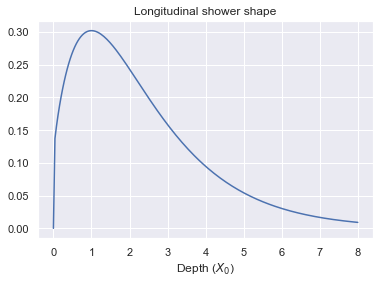

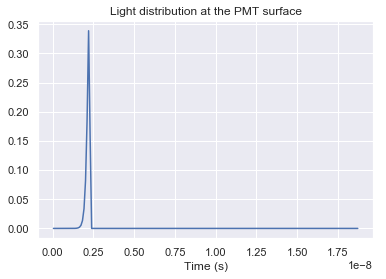

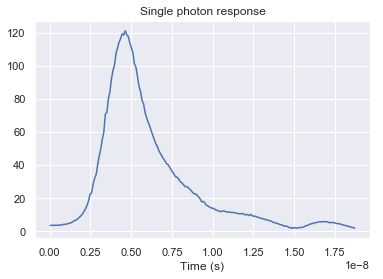

 79%|███████▉  | 7879526/10000000 [01:10<00:18, 112473.41it/s]

In [ ]:
%run pmt_signal.py 10000000 --plot --save